In [ ]:
import PyPlot

In [ ]:
function MotionPrimitives(car_length,car_width,h,Δt,v_min,v_max,v_steps,δ_max,δ_min,δ_steps)
    """
    Return a library of motion primitives (arcs of constant radius) representing short paths that the car can follow.
    """
    # 3D array to store motion_primitives
    motion_primitives = zeros(v_steps,2*δ_steps+1,2) # v: 0,...,99; δ: -45:45, (arc length, +/- radius)

    v = linspace(v_min,v_max,v_steps)*ones(1,2*δ_steps+1)
    δ = (linspace(-δ_max,δ_max,δ_steps*2+1)*ones(1,v_steps))' # steering angle

    motion_primitives[:,:,1] = v*Δt*h # arc length = velocity * time
    motion_primitives[:,:,2] = car_length./sin(δ) # radius of curvature (+ or -)
    motion_primitives[:,1+δ_steps,2] = Inf; # radius of curvature is infinite if steering angle = 0

    destination_primitives = zeros(v_steps,2*δ_steps+1,h,3) # lookup table defining car's location at each of next h time steps

    for i = 1:h
        # angle = 2π * arc_length / r
        dθ = v*Δt*i ./ motion_primitives[:,:,2]

        # dX = abs(radius) * sin(angle)
        destination_primitives[:,:,i,1] = abs(motion_primitives[:,:,2]) .* sin(abs(dθ))
        destination_primitives[:,1+δ_steps,i,1] = v[:,1+δ_steps]*Δt*i # centerline

        # dY = radius * (1 - cos(angle))
        destination_primitives[:,:,i,2] = motion_primitives[:,:,2].*(1 - cos(dθ))
        destination_primitives[:,1+δ_steps,i,2] = 0 # centerline

        destination_primitives[:,:,i,3] = dθ
    end

    # destination_primitives[v, δ, h, 1=Δx,2=Δy,3=Δθ]= changes in x, y and θ after h time steps
    
    return v, δ, destination_primitives
end

In [ ]:
car_length = 4.8
wheel_base = car_length
car_width = 1.5
h = 10
Δt = 1/24.0
v_min = 0.0
v_max = 100.0
δ_max = Float64(π)/6.0
δ_min = -δ_max
μ = 20.0
g = 9.81

In [ ]:
δ_step = Float64(π)/128

ΔT = 2.5 # seconds to go from 0 to 60
ΔV = 60*1600/3600 # 0->60 mph = 0->26.6 m/s
a_max = ΔV/ΔT # maximum acceleration = 10.66 m/s^2
v_step = a_max*Δt

In [ ]:
function GenerateMotionMap(v_min,v_max,a_max,δ_max,δ_step,wheel_base,h,μ,Δt)
    
    v_step = a_max*Δt
    v_range = linspace(v_min,v_max,round(v_max/v_step))
    δ_range = linspace(-δ_max,δ_max,2*round((δ_max)/δ_step)+1)
    R_range = wheel_base./tan(δ_range)
    a_range = [-1,0,1]
    motion_map = Dict()
    v_map = Dict()
    δ_map = Dict()

    for v_idx in 1:length(v_range)
        v = v_range[v_idx]
        v_map[v_idx] = zeros(Int,length(a_range),length(δ_range))
        δ_map[v_idx] = zeros(Int,length(a_range),length(δ_range))
        for a_idx in 1:length(a_range)
            Δv_idx = a_range[a_idx]
            tire_force = sqrt(((v^2)./abs(R_range)).^2 + (Δv_idx*a_max)^2)
            if v_idx + Δv_idx >= 1 && v_idx + Δv_idx <= length(v_range)
                v_map[v_idx][a_idx,:] = Int(v_idx + Δv_idx)# v_range[v_idx+Δv_idx]
            else
                v_map[v_idx][a_idx,:] = Int(v_idx) #v_range[v_idx]
            end
            if v_idx > 1
                for j in 1:length(δ_range)
                    if tire_force[j] >= μ*g
                        v_map[v_idx][a_idx,j] = Int(v_idx) - 1# v_range[v_idx-1] # decelerate
                    end
                end
            end
            #δ_map[v_idx][a_idx,:] = δ_range.*(tire_force .< μ*g) + 
             #   maximum(abs(δ_range[tire_force .< μ*g])).*sign(δ_range).*(tire_force .>= μ*g)
            δ_map[v_idx][a_idx,:] = [i for i in 1:length(δ_range)].*(tire_force .< μ*g) + 
            indmax(abs(δ_range).*(tire_force .< μ*g)).*(tire_force .>= μ*g).*-sign(δ_range) + 
            (length(δ_range)+1).*(sign(δ_range) .> 0).*(tire_force .>= μ*g)
        end
    end


    # fill motion map
    for v_idx in 1:length(v_range)
        motion_map[v_idx] = zeros(length(a_range),length(δ_range),h,3)
        level_v_idx = copy(v_map[v_idx])
        level_δ_idx = copy(δ_map[v_idx])
        Δθ = zeros(length(a_range),length(δ_range))
        for i in 1:h
            radius = wheel_base./tan(δ_range[level_δ_idx])
            Δs = ((v_range[v_idx] + v_range[level_v_idx])./2.0)*Δt
            Δθ = Δs./radius
            ΔX = abs(radius) .* sin(abs(Δθ))
            ΔX[:,Int((length(δ_range)-1)/2)+1] = Δs[:,Int((length(δ_range)-1)/2)+1]
            ΔY = radius.*(1 - cos(Δθ))
            ΔY[:,Int((length(δ_range)-1)/2)+1] = 0
            if i == 1
                motion_map[v_idx][:,:,i,1] = ΔX
                motion_map[v_idx][:,:,i,2] = ΔY
                motion_map[v_idx][:,:,i,3] = Δθ
            else
                motion_map[v_idx][:,:,i,1] = motion_map[v_idx][:,:,i-1,1] + 
                    ΔX.*cos(motion_map[v_idx][:,:,i-1,3]) - ΔY.*sin(motion_map[v_idx][:,:,i-1,3])
                motion_map[v_idx][:,:,i,2] = motion_map[v_idx][:,:,i-1,2] + 
                    ΔX.*sin(motion_map[v_idx][:,:,i-1,3]) + ΔY.*cos(motion_map[v_idx][:,:,i-1,3])
                motion_map[v_idx][:,:,i,3] = Δθ + motion_map[v_idx][:,:,i-1,3]  # + motion_map[v_idx][:,:,i-1,3]
            end
            for j in 1:length(level_v_idx) # update to next velocity
                level_v_idx[j] = v_map[level_v_idx[j]][j]
                level_δ_idx[j] = δ_map[level_v_idx[j]][j]
            end
        end
    end
    return motion_map, v_map, δ_map, v_range, δ_range
end

In [ ]:
mapHRHC()

In [ ]:
motion_map, v_map, δ_map, v_range, δ_range = GenerateMotionMap(v_min,v_max,a_max,δ_max,δ_step,wheel_base,h,μ,Δt)
motion_map;

In [ ]:
v_idx = 160
δ_idx = 18
a_idx = 3
ΔXYθ = motion_map[v_idx][:,:,h,:]
trajectory = motion_map[v_idx][a_idx,:,:,:]
for i in 1:size(trajectory,1)
    PyPlot.plot(trajectory[i,:,2],trajectory[i,:,1],c="red")
end
PyPlot.plot(trajectory[δ_idx,:,2],trajectory[δ_idx,:,1],c="lime",linewidth=2)
PyPlot.scatter(ΔXYθ[:,:,2],ΔXYθ[:,:,1],edgecolor="none")

PyPlot.axis("equal")

In [ ]:
# generate full motion primitives
v_range = linspace(v_min,v_max,round(v_max/v_step))
δ_range = linspace(-δ_max,δ_max,2*round((δ_max)/δ_step)+1)
R_range = wheel_base./tan(δ_range)
a_range = [-1,0,1]
motion_map = Dict()
v_map = Dict()
δ_map = Dict()
h = 10

for v_idx in 1:length(v_range)
    v = v_range[v_idx]
    v_map[v_idx] = zeros(Int,length(a_range),length(δ_range))
    δ_map[v_idx] = zeros(Int,length(a_range),length(δ_range))
    for a_idx in 1:length(a_range)
        Δv_idx = a_range[a_idx]
        tire_force = sqrt(((v^2)./abs(R_range)).^2 + (Δv_idx*a_max)^2)
        if v_idx + Δv_idx >= 1 && v_idx + Δv_idx <= length(v_range)
            v_map[v_idx][a_idx,:] = Int(v_idx + Δv_idx)# v_range[v_idx+Δv_idx]
        else
            v_map[v_idx][a_idx,:] = Int(v_idx) #v_range[v_idx]
        end
        if v_idx > 1
            for j in 1:length(δ_range)
                if tire_force[j] >= μ*g
                    v_map[v_idx][a_idx,j] = Int(v_idx) - 1# v_range[v_idx-1] # decelerate
                end
            end
        end
        #δ_map[v_idx][a_idx,:] = δ_range.*(tire_force .< μ*g) + 
         #   maximum(abs(δ_range[tire_force .< μ*g])).*sign(δ_range).*(tire_force .>= μ*g)
        δ_map[v_idx][a_idx,:] = [i for i in 1:length(δ_range)].*(tire_force .< μ*g) + 
        indmax(abs(δ_range).*(tire_force .< μ*g)).*(tire_force .>= μ*g).*-sign(δ_range) + 
        (length(δ_range)+1).*(sign(δ_range) .> 0).*(tire_force .>= μ*g)
    end
end


# fill motion map
for v_idx in 1:length(v_range)
    motion_map[v_idx] = zeros(length(a_range),length(δ_range),h,3)
    level_v_idx = copy(v_map[v_idx])
    level_δ_idx = copy(δ_map[v_idx])
    Δθ = zeros(length(a_range),length(δ_range))
    for i in 1:h
        radius = wheel_base./tan(δ_range[level_δ_idx])
        Δs = ((v_range[v_idx] + v_range[level_v_idx])./2.0)*Δt
        Δθ = Δs./radius
        ΔX = abs(radius) .* sin(abs(Δθ))
        ΔX[:,Int((length(δ_range)-1)/2)+1] = Δs[:,Int((length(δ_range)-1)/2)+1]
        ΔY = radius.*(1 - cos(Δθ))
        ΔY[:,Int((length(δ_range)-1)/2)+1] = 0
        if i == 1
            motion_map[v_idx][:,:,i,1] = ΔX
            motion_map[v_idx][:,:,i,2] = ΔY
            motion_map[v_idx][:,:,i,3] = Δθ
        else
            motion_map[v_idx][:,:,i,1] = motion_map[v_idx][:,:,i-1,1] + 
                ΔX.*cos(motion_map[v_idx][:,:,i-1,3]) - ΔY.*sin(motion_map[v_idx][:,:,i-1,3])
            motion_map[v_idx][:,:,i,2] = motion_map[v_idx][:,:,i-1,2] + 
                ΔX.*sin(motion_map[v_idx][:,:,i-1,3]) + ΔY.*cos(motion_map[v_idx][:,:,i-1,3])
            motion_map[v_idx][:,:,i,3] = Δθ + motion_map[v_idx][:,:,i-1,3]  # + motion_map[v_idx][:,:,i-1,3]
        end
        for j in 1:length(level_v_idx) # update to next velocity
            level_v_idx[j] = v_map[level_v_idx[j]][j]
            level_δ_idx[j] = δ_map[level_v_idx[j]][j]
        end
    end
end

In [ ]:
"""
Return a library of motion primitives (arcs of constant radius) representing short paths that the car can follow.
"""
# 3D array to store motion_primitives
# radius = zeros(v_steps,2*δ_steps+1) # v: 0,...,99; δ: -45:45, (arc length, +/- radius)

v = linspace(v_min,v_max,round(v_max/v_step))*ones(1,2*Int(round((δ_max)/δ_step))+1) # velocity
δ = (linspace(-δ_max,δ_max,2*round((δ_max)/δ_step)+1)*ones(1,Int(round(v_max/v_step))))' # steering angle

radius = car_length./sin(δ) # radius of curvature (+ or -)
radius[:,Int(round((δ_max)/δ_step))+1] = Inf; # radius of curvature is infinite if steering angle = 0

destination_primitives = zeros(size(v,1),size(v,2),3,h,3)

accels = [-a_max,0,a_max]
for j in 1:3
    v₀ = copy(v)
    a = accels[j]
    for i = 1:h
        vᵢ = v₀+a*i*Δt # velocity at end of time step
        tire_force = sqrt((((vᵢ).^2)./abs(radius)).^2 + a^2) # tire force must be less than μ*g
        v_threshold = ones(size(v,1),1)*maximum(vᵢ.*(tire_force .< μ*g), 1)
        vᵢ = min(vᵢ,v_threshold)
        Δs = max((v₀+vᵢ)/2.0, 0.0)*i*Δt
        
        Δθ = Δs./radius # change in heading
        v₀[1:end-i,:] = v[i+1:end,:] # increase v₀ by one step for next round

        # dX = abs(radius) * sin(angle)
        destination_primitives[:,:,j,i,1] = abs(radius) .* sin(abs(Δθ))
        destination_primitives[:,Int(round((δ_max)/δ_step))+1,j,i,1] = Δs[:,Int(round((δ_max)/δ_step))+1] # centerline

        # dY = radius * (1 - cos(angle))
        destination_primitives[:,:,j,i,2] = radius.*(1 - cos(Δθ))
        destination_primitives[:,Int(round((δ_max)/δ_step))+1,j,i,2] = 0 # centerline

        destination_primitives[:,:,j,i,3] = Δθ
    end
end

In [ ]:
function MotionPrimitivesAcceleration(wheel_base,h,Δt,v_min,v_max,v_step,δ_min,δ_max,δ_step,μ)
    """
    Return a library of motion primitives (arcs of constant radius) representing short paths that the car can follow.
    """
    # 3D array to store motion_primitives
    # radius = zeros(v_steps,2*δ_steps+1) # v: 0,...,99; δ: -45:45, (arc length, +/- radius)
    g = 9.81
    v = linspace(v_min,v_max,round(v_max/v_step))*ones(1,2*Int(round((δ_max)/δ_step))+1) # velocity
    δ = (linspace(-δ_max,δ_max,2*round((δ_max)/δ_step)+1)*ones(1,Int(round(v_max/v_step))))' # steering angle

    radius = wheel_base./sin(δ) # radius of curvature (+ or -)
    radius[:,Int(round((δ_max)/δ_step))+1] = Inf; # radius of curvature is infinite if steering angle = 0
    
    n_actions = 3 # slow down, stay, speed up
    destination_primitives = zeros(size(v,1),size(v,2),n_actions,h,3)

    accels = [-a_max,0,a_max]
    for j in 1:3
        v₀ = copy(v)
        a = accels[j]
        for i = 1:h
            vᵢ = max(v₀+a*i*Δt, 0.0) # velocity at end of time step
            tire_force = sqrt((((vᵢ).^2)./abs(radius)).^2 + a^2) # tire force must be less than μ*g
            v_threshold = ones(size(v,1),1)*maximum(vᵢ.*(tire_force .< μ*g), 1)
            vᵢ = min(vᵢ,v_threshold)
            Δs = max((v₀+vᵢ)/2.0, 0.0)*i*Δt

            Δθ = Δs./radius # change in heading
            if j == 3 # accel = -1
                v₀[1:end-i,:] = v[i+1:end,:] # increase v₀ by one step for next round
            elseif j == 1 # accel = +1
                v₀[i+1:end,:] = v[1:end-i,:] # increase v₀ by one step for next round
            end
            # dX = abs(radius) * sin(angle)
            destination_primitives[:,:,j,i,1] = abs(radius) .* sin(abs(Δθ))
            destination_primitives[:,Int(round((δ_max)/δ_step))+1,j,i,1] = Δs[:,Int(round((δ_max)/δ_step))+1] # centerline

            # dY = radius * (1 - cos(angle))
            destination_primitives[:,:,j,i,2] = radius.*(1 - cos(Δθ))
            destination_primitives[:,Int(round((δ_max)/δ_step))+1,j,i,2] = 0 # centerline

            destination_primitives[:,:,j,i,3] = Δθ
        end
    end
    
    tire_force = sqrt((((v).^2)./abs(radius)).^2) # tire force must be less than μ*g
    mask = (tire_force .< μ*g)
    v_threshold = ones(size(v,1),1)*maximum(v.*mask, 1)
    v = min(v,v_threshold)
    motion_map = Dict()
    for i in 1:size(v,1) # motion_map[i] contains the reachable states from v[i]
        motion_map[i] = destination_primitives[i,:,:,:,:]
    end
    
    return v, δ, destination_primitives, motion_map, mask
end

In [ ]:
v, δ, destination_primitives, motion_map, mask = MotionPrimitivesAcceleration(car_length,h,Δt,v_min,v_max,v_step,δ_min,δ_max,δ_step,μ)
destination_primitives;

In [ ]:
tire_force = sqrt((((v).^2)./abs(radius)).^2)
PyPlot.scatter(δ[tire_force .< μ*g],v[tire_force .< μ*g],c=tire_force[tire_force .< μ*g],edgecolor="none")

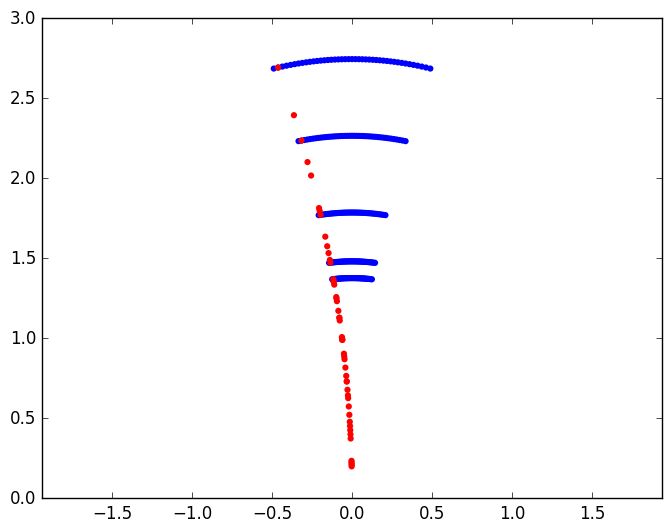

(-0.6000000000000001,0.6000000000000001,0.0,3.0)

In [25]:
v_idx = 14
δ_idx = 1
a_idx = 2
ΔXYθ = car1.motion_map[v_idx][:,:,10,:]
trajectory = car1.motion_map[v_idx][:,a_idx,:,:]
PyPlot.scatter(ΔXYθ[:,:,2],ΔXYθ[:,:,1],edgecolor="none")
PyPlot.scatter(trajectory[:,:,2],trajectory[:,:,1],c="red",edgecolor="none")
PyPlot.axis("equal")

In [ ]:
radius = car_length./sin(δ) # radius of curvature (+ or -)
# mask for tire saturation
tire_force⁺ = sqrt(((v₀.^2)./abs(radius)).^2 + a_max^2)
tire_force⁰ = sqrt(((v₀.^2)./abs(radius)).^2 + 0)
tire_force⁻ = sqrt(((v₀.^2)./abs(radius)).^2 + a_max^2)

# Plot tire force saturation threshold
PyPlot.figure(figsize=[12,4])
PyPlot.subplot(1,3,1)
PyPlot.title("Tire Forces +")
PyPlot.scatter(δ[tire_force⁺ .< μ*g]*180.0/Float64(π),v[tire_force⁺ .< μ*g],c=tire_force⁺[tire_force⁺ .< μ*g],edgecolor="none")
PyPlot.xlabel("Steering Angle (degrees)")
PyPlot.ylabel("Tangential Velocity (m/s)")
PyPlot.axis("tight")
PyPlot.subplot(1,3,2)
PyPlot.title("Tire Forces 0")
PyPlot.scatter(δ[tire_force⁰ .< μ*g]*180.0/Float64(π),v[tire_force⁰ .< μ*g],c=tire_force⁰[tire_force⁰ .< μ*g],edgecolor="none")
PyPlot.xlabel("Steering Angle (degrees)")
# PyPlot.ylabel("Tangential Velocity (m/s)")
PyPlot.axis("tight")
PyPlot.subplot(1,3,3)
PyPlot.title("Tire Forces -")
PyPlot.scatter(δ[tire_force⁻ .< μ*g]*180.0/Float64(π),v[tire_force⁻ .< μ*g],c=tire_force⁻[tire_force⁻ .< μ*g],edgecolor="none")
PyPlot.xlabel("Steering Angle (degrees)")
# PyPlot.ylabel("Tangential Velocity (m/s)")
PyPlot.axis("tight")

In [ ]:
# v_threshold = ones(size(v,1),1)*maximum(v₀.*(tire_force⁰ .< μ*g),1)
# v₀[1:end-1,:] = v[1+1:end,:]
# v₀ = min(v₀,v_threshold)
PyPlot.scatter(δ,v,edgecolor="none",c=v)

## Modify HRHC parameters

In [1]:
using AutomotiveDrivingModels
using AutoViz
using SplineRaceWay
using SplineUtils
using NearestNeighbors
using HierarchicalRecedingHorizonController

/Users/kyle/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# scene parameters
scene = Scene()
framerate = 24
Δt = 1.0/framerate # size of rendering timesteps
h = 15
n_integration_sub_steps = 3 # sub steps for smoother integration
context = IntegratedContinuous(Δt, n_integration_sub_steps) # integrated continuous context

#car parameters
car_length = 4.8 # front wheel to back wheel
car_width = 2.5
v⁰  = 0.0 # initial velocity
δ⁰ = 0.0 # initical steering angle

############### INITIALIZE TRACK ################

lane_width = 8.0*DEFAULT_LANE_WIDTH
radius = 45.0
edge_buffer = 0.25
T_MAX = lane_width/2.0 - car_width/2.0 - edge_buffer # max allowable projection distance from center of lane
base_speed= 0.0

# spline control points
# Pts = 40*[0 -1 -2 -3 -3 -3 -2 -1 -1 -1 -2 -3 -4 -5 -5 -5 -5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
#          0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]
Pts = 40*[0 -1 -2 -3 -3.5 -3 -2 -1 -0.5 -1 -2 -3 -4 -5 -5.5 -5 -4.5 -5 -5 -4 -3 -2 -1 -1 -1 0 1 1 1 2 3 4 5 5 5 5 5 5 5 4 3 3 3 3 2 1 0; 
       0 0 0 0 -1 -2 -2 -2 -3 -4 -4 -4 -4 -4 -3 -2 -1 0 1 2 3 4 4 3 2 2 2 3 4 4 4 4 3 2 1 0 -1 -2 -3 -4 -3 -2 -1 0 0 0 0]

degree = 3 # degree of spline
num_points = 10001
num_samples = 420
lane_width = 20.0
track = Raceway(Pts,degree,num_points,num_samples,lane_width)
track;

In [3]:
car1 = mapHRHC(1,track.roadway,context,a_step=10.0,a_range=[-3,-2,-1,0,1])
car2 = accelHRHC(2,track.roadway,context)
car3 = HRHC(3,track.roadway,context)
car1;

In [4]:
roadind1 = RoadIndex(CurveIndex(20,0),LaneTag(1,1))
roadind2 = RoadIndex(CurveIndex(10,0),LaneTag(1,1))
roadind3 = RoadIndex(CurveIndex(1,0),LaneTag(1,1))

vehstate1 = VehicleState(Frenet(roadind1, track.roadway), track.roadway, 0.0)
vehstate2 = VehicleState(Frenet(roadind2, track.roadway), track.roadway, 0.0)
vehstate3 = VehicleState(Frenet(roadind3, track.roadway), track.roadway, 0.0)

vehdef1 = VehicleDef(1,AgentClass.CAR, car_length, car_width)
vehdef2 = VehicleDef(2,AgentClass.CAR, car_length, car_width)
vehdef3 = VehicleDef(3,AgentClass.CAR, car_length, car_width)

push!(scene,Vehicle(vehstate1, vehdef1))
push!(scene,Vehicle(vehstate2, vehdef2))
push!(scene,Vehicle(vehstate3, vehdef3))

carcolors = Dict{Int, Colorant}()
carcolors[1] = colorant"red"
carcolors[2] = colorant"blue"
carcolors[3] = colorant"yellow"

# hrhc = HRHC(1,roadway,context)
track.models[1] = car1
track.models[2] = car2
track.models[3] = car3
track.obstacleMap = generateObstacleMap(scene, track.models)
actions = Array(DriveAction, length(scene))

3-element Array{AutomotiveDrivingModels.DriveAction,1}:
 #undef
 #undef
 #undef

In [ ]:
# car.successor_states = getSuccessorStates!(car.motion_map[car.v_cmd],car.car_ID,car.h,scene)
s,t,ϕ = loopProjectionKD(car3,scene,track.roadway,track.tree)
s

In [ ]:
car1.successor_states

In [ ]:
scene.vehicles[car1.car_ID].state

In [ ]:
# trajectory = computeTrajectory(car.motion_map[car.v_cmd], car.car_ID, scene, car.v_cmd, car.δ_cmd, car.h)

In [ ]:
calculateObjective(car3, scene, track.roadway, track.tree, s, t, ϕ, track.obstacleMap, car3.k, car3.h)

In [ ]:
observe!(car3,scene,track.roadway,car3.car_ID,track.tree,track.obstacleMap,car3.k)

In [ ]:
car1.v_cmd, car1.δ_cmd

In [ ]:
render(scene,track.roadway)